In [11]:
import torch
import random
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

citeseer_dataset = Planetoid("data", name="Citeseer", transform=NormalizeFeatures())

Processing...
Done!


In [25]:
citeseer_graph = citeseer_dataset[0]
citeseer_graph

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [26]:
citeseer_graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
citeseer_graph.y

tensor([3, 1, 5,  ..., 3, 1, 5])

In [28]:
print("Training samples: ", citeseer_graph.train_mask.sum().item())
print("Validation samples: ", citeseer_graph.val_mask.sum().item())
print("Test samples: ", citeseer_graph.test_mask.sum().item())

Training samples:  120
Validation samples:  500
Test samples:  1000


In [29]:
print("Number of nodes: ", citeseer_graph.num_nodes)
print("Number of edges: ", citeseer_graph.num_edges)
print(f"Average node degree: {citeseer_graph.num_edges / citeseer_graph.num_nodes:.2f}")
print("Has isolated nodes: ", citeseer_graph.has_isolated_nodes())
print("Has self-loops: ", citeseer_graph.has_self_loops())
print("Is undirected: ", citeseer_graph.is_undirected())

Number of nodes:  3327
Number of edges:  9104
Average node degree: 2.74
Has isolated nodes:  True
Has self-loops:  False
Is undirected:  True


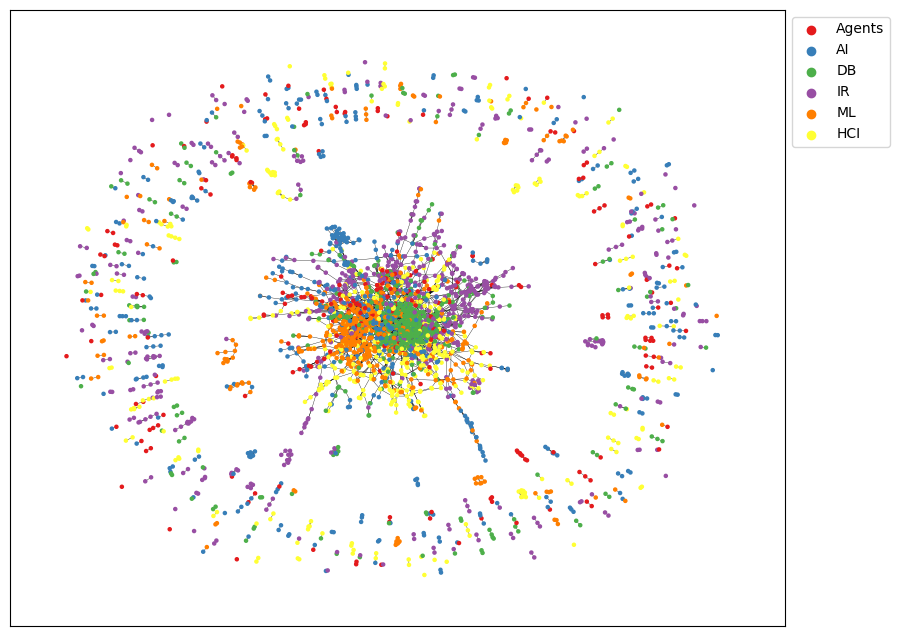

In [32]:
import networkx as nx
from torch_geometric.utils import to_networkx

label_dict = {
    0: "Agents",
    1: "AI",
    2: "DB",
    3: "IR",
    4: "ML",
    5: "HCI"
}

color_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']

G = to_networkx(citeseer_graph, to_undirected=True)

node_color = [color_list[int(label)] for label in citeseer_graph.y]
label_list = [label_dict[int(label)] for label in citeseer_graph.y]

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10,8))
nx.draw_networkx_nodes(G, pos, node_size= 5, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=0.25)

for label, color in zip(label_dict.values(), color_list):
    plt.scatter([], [], c=color, label=label)

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
import torch.nn as nn
import torch.optim as optimizer

class MLP(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=input_channels, out_features=hidden_channels),
            nn.ReLU(),
            nn.Linear(in_features=hidden_channels, out_features=output_channels)
        )

    def forward(self, data):
        x = data.x
        output = self.layers(x)
        return output

In [44]:
input_channels = citeseer_dataset.num_features
hidden_channels = 16
output_channels = citeseer_dataset.num_classes

model = MLP(
    input_channels=input_channels,
    hidden_channels=hidden_channels,
    output_channels=output_channels
)

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3703, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):

    model.train()
    optimizer.zero_grad()
    out = model(citeseer_graph)

    loss = criterion(out[citeseer_graph.train_mask], citeseer_graph.y[citeseer_graph.train_mask])
    loss.backward()

    optimizer.step()

    # Predictions on the training data
    pred_train = out.argmax(dim = 1)
    
    correct_train = (
        pred_train[citeseer_graph.train_mask] == citeseer_graph.y[citeseer_graph.train_mask]
    ).sum()
    
    acc_train = int(correct_train) / int(citeseer_graph.train_mask.sum())
    
    # Predictions on validation data
    model.eval()

    pred_val = model(citeseer_graph).argmax(dim = 1)
    
    correct_val = (
        pred_val[citeseer_graph.val_mask] == citeseer_graph.y[citeseer_graph.val_mask]
    ).sum()
    
    acc_val = int(correct_val) / int(citeseer_graph.val_mask.sum())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1:03d}, \
               Train Loss: {loss:.3f}, \
               Train Acc: {acc_train:.3f} Val Acc: {acc_val:.3f}')

Epoch: 010,                Train Loss: 1.698,                Train Acc: 0.850 Val Acc: 0.352
Epoch: 020,                Train Loss: 1.493,                Train Acc: 1.000 Val Acc: 0.426
Epoch: 030,                Train Loss: 1.201,                Train Acc: 1.000 Val Acc: 0.496
Epoch: 040,                Train Loss: 0.881,                Train Acc: 1.000 Val Acc: 0.518
Epoch: 050,                Train Loss: 0.624,                Train Acc: 1.000 Val Acc: 0.506
Epoch: 060,                Train Loss: 0.463,                Train Acc: 1.000 Val Acc: 0.514
Epoch: 070,                Train Loss: 0.369,                Train Acc: 1.000 Val Acc: 0.524
Epoch: 080,                Train Loss: 0.312,                Train Acc: 1.000 Val Acc: 0.526
Epoch: 090,                Train Loss: 0.273,                Train Acc: 1.000 Val Acc: 0.546
Epoch: 100,                Train Loss: 0.245,                Train Acc: 1.000 Val Acc: 0.554
Epoch: 110,                Train Loss: 0.223,                Train Acc